# Monitor de Discursos de Odio en Redes Sociales – Notebook EDA

Este notebook documenta el proceso de extracción, procesamiento y análisis exploratorio de tweets relacionados con discursos de odio en redes sociales, desarrollado como parte de un proyecto del CIAI (Centro de Investigación en Inteligencia Artificial de la UNSAM).

El objetivo del proyecto es monitorear y analizar la presencia y características de discursos de odio en la plataforma X (antes Twitter), generando información útil para investigaciones académicas y aplicaciones prácticas en la detección de contenido nocivo en redes sociales. Este análisis contribuye al desarrollo de herramientas y metodologías basadas en inteligencia artificial que permitan entender mejor cómo circula el discurso de odio y cómo se relaciona con eventos sociales y políticos.

In [32]:
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import login

# Leer CSV (METODO VISUALMENTE PREFERENTE)
tweets = pd.read_csv(
    "tweets_base3.csv",
    engine='python',           # motor más tolerante
    sep=',',
    quotechar='"',             # reconoce comillas
    quoting=csv.QUOTE_ALL,
    on_bad_lines='skip',       # ignorar filas corruptas
    encoding='utf-8'
)

# Visualizamos las primeras filas
tweets.head()

,fecha,user,tweet,url,fecha_captura
0,2025-08-26 23:31:14,@Raylordex,\r\nPORFIN CONOCI A LA XIME y a algunos amigos...,https://x.com/Raylordex/status/196048521766102...,2025-08-27 19:49:16.314156
1,2025-08-26 23:28:24,@portalmvd,\r\nMinistro del Interior citó a jefe policial...,https://x.com/portalmvd/status/196048450220088...,2025-08-27 19:49:16.314156
2,2025-08-26 23:08:44,@GritesNo,"\r\nEsto era lo que le sacaba Zamora m, que si...",https://x.com/GritesNo/status/1960479554520408084,2025-08-27 19:49:16.314156
3,2025-08-26 23:01:03,@Calcio0822,\r\n ¡Refuerzo nerazzurro!\r\n\r\n¡Calvin Sten...,https://x.com/Calcio0822/status/19604776210679...,2025-08-27 19:49:16.314156
4,2025-08-26 22:39:20,@TheMpminiBooks,"\r\nAsí es, pero me pasa lo mismo con todas la...",https://x.com/TheMpminiBooks/status/1960472156...,2025-08-27 19:49:16.314156


### Analisis exploratorio de datos

In [33]:
# Información general
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7426 entries, 0 to 7425
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fecha          7426 non-null   object
 1   user           7426 non-null   object
 2   tweet          7426 non-null   object
 3   url            7426 non-null   object
 4   fecha_captura  7426 non-null   object
dtypes: object(5)
memory usage: 290.2+ KB


In [34]:
tweets.describe(include='all')

,fecha,user,tweet,url,fecha_captura
count,7426,7426,7426,7426,7426
unique,5642,6018,7249,7426,8
top,2025-08-28 23:10:08,@LaresSusy,#Coimera,https://x.com/peronynadama/status/196011509186...,2025-08-30 12:55:46.161569
freq,5,29,32,1,3303


El dataset contiene 7426 tweets sobre discursos de odio, con cinco columnas (fecha, user, tweet, url y fecha_captura), todas completas sin valores nulos. Se observa que la mayoría de los tweets son únicos (7249 textos distintos) y provienen de 6018 usuarios distintos, aunque algunos publicaron varias veces. Cada tweet tiene una URL única, y la columna fecha_captura indica que los datos fueron extraídos en 8 sesiones.

Para un mejor manejo de los datos se procedio a convertir las variables de fecha en tipo de datos datetime

In [35]:
# Convertir columnas de texto a datetime
tweets['fecha'] = pd.to_datetime(tweets['fecha'], errors='coerce')
tweets['fecha_captura'] = pd.to_datetime(tweets['fecha_captura'], errors='coerce')


tweets.dtypes


,0
fecha,datetime64[ns]
user,object
tweet,object
url,object
fecha_captura,datetime64[ns]


In [36]:
# Revisar primeras filas y tipos
tweets.head(5)


,fecha,user,tweet,url,fecha_captura
0,2025-08-26 23:31:14,@Raylordex,\r\nPORFIN CONOCI A LA XIME y a algunos amigos...,https://x.com/Raylordex/status/196048521766102...,2025-08-27 19:49:16.314156
1,2025-08-26 23:28:24,@portalmvd,\r\nMinistro del Interior citó a jefe policial...,https://x.com/portalmvd/status/196048450220088...,2025-08-27 19:49:16.314156
2,2025-08-26 23:08:44,@GritesNo,"\r\nEsto era lo que le sacaba Zamora m, que si...",https://x.com/GritesNo/status/1960479554520408084,2025-08-27 19:49:16.314156
3,2025-08-26 23:01:03,@Calcio0822,\r\n ¡Refuerzo nerazzurro!\r\n\r\n¡Calvin Sten...,https://x.com/Calcio0822/status/19604776210679...,2025-08-27 19:49:16.314156
4,2025-08-26 22:39:20,@TheMpminiBooks,"\r\nAsí es, pero me pasa lo mismo con todas la...",https://x.com/TheMpminiBooks/status/1960472156...,2025-08-27 19:49:16.314156


### Limpieza y Preprocesamiento del Texto

Antes de realizar análisis sobre el contenido de los tweets, es necesario limpiar y preprocesar el texto para eliminar ruido y normalizarlo. Esto incluye:

- Eliminar caracteres especiales, URLs, menciones de usuarios y hashtags.
- Convertir el texto a minúsculas.
- Eliminar espacios en blanco adicionales.

In [37]:
# Definir función de limpieza
def clean_tweet(tweet):
    if not isinstance(tweet, str):  # Si no es string, devolver vacío
        return ""

    # Eliminar URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Eliminar menciones de usuarios
    tweet = re.sub(r'@\w+', '', tweet)
    # Eliminar hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    # Eliminar caracteres especiales y números
    tweet = re.sub(r'[^A-Za-zñÑáéíóúÁÉÍÓÚüÜ\s]+', '', tweet)
    # Convertir a minúsculas
    tweet = tweet.lower()
    # Eliminar espacios en blanco adicionales
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

# Eliminar filas con NaN en la columna 'tweet'
tweets = tweets.dropna(subset=['tweet'])

# Aplicar limpieza
tweets['tweet_processed'] = tweets['tweet'].apply(clean_tweet)

# Ver los primeros resultados
print(tweets[['tweet', 'tweet_processed']].head())

                                               tweet  \
0  \r\nPORFIN CONOCI A LA XIME y a algunos amigos...   
1  \r\nMinistro del Interior citó a jefe policial...   
2  \r\nEsto era lo que le sacaba Zamora m, que si...   
3  \r\n ¡Refuerzo nerazzurro!\r\n\r\n¡Calvin Sten...   
4  \r\nAsí es, pero me pasa lo mismo con todas la...   

                                     tweet_processed  
0  porfin conoci a la xime y a algunos amigos de ...  
1  ministro del interior citó a jefe policial de ...  
2  esto era lo que le sacaba zamora m que si mal ...  
3  refuerzo nerazzurro calvin stengs del feyenoor...  
4  así es pero me pasa lo mismo con todas las pel...  


### Análisis de la Longitud de los Tweets

Exploraremos la longitud de los tweets antes y después del preprocesamiento para entender cómo varía y si hay tweets muy cortos o muy largos que puedan requerir un tratamiento especial.

In [38]:
tweets['tweet_length'] = tweets['tweet'].apply(len)
tweets['tweet_processed_length'] = tweets['tweet_processed'].apply(len)

# Estadísticas descriptivas de la longitud
display(tweets[['tweet_length', 'tweet_processed_length']].describe())

# Tweet más largo y más corto (procesado)
max_length_tweet = tweets.loc[tweets['tweet_processed_length'].idxmax()]
min_length_tweet = tweets.loc[tweets['tweet_processed_length'].idxmin()]

print(f"\nTweet más largo (procesado):\n{max_length_tweet['tweet_processed']}")
print(f"\nTweet más corto (procesado):\n{min_length_tweet['tweet_processed']}")

,tweet_length,tweet_processed_length
count,7426.000000,7426.000000
mean,124.694587,109.289793
std,83.486529,77.687082
min,4.000000,0.000000
25%,54.000000,45.000000
50%,104.000000,90.000000
75%,186.750000,162.000000
max,415.000000,280.000000



Tweet más largo (procesado):
bue alguien que apoya a lilita convengamos que la dagor tiene algunos jugadores con amarilla querida lávate bien la boca antes de hablar de mm ya que peleo con el pj bien parado y internamente con tu parásito d amiga a lilita dale un micrófono y la tendrás días hablando boludeces

Tweet más corto (procesado):



Luego, para obtener mayor informacion se procedio a realizar un histograma. El cual brinda informacion estadistica acerca de la longitud de los tweets.
Este analisis sirve para obtener una idea inicial de la informacion que manejamos.

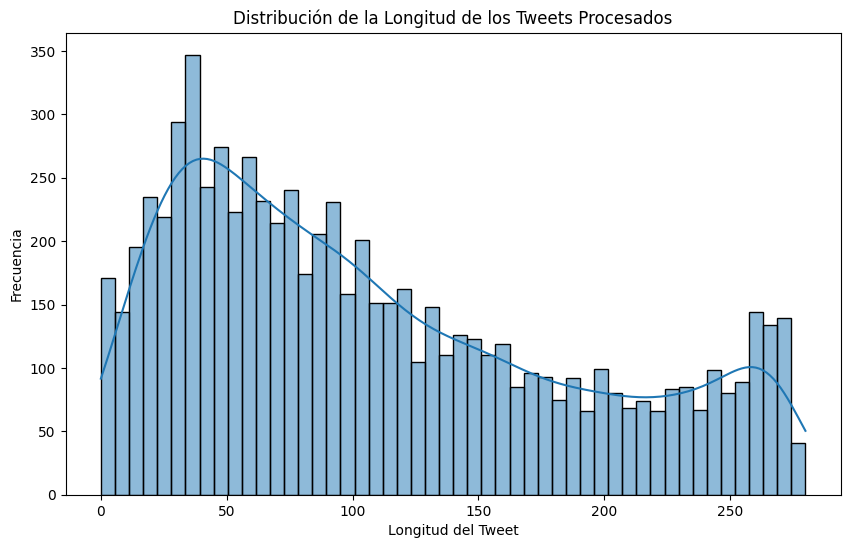

In [39]:
# Histograma de la longitud de los tweets procesados
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_processed_length'], bins=50, kde=True)
plt.title('Distribución de la Longitud de los Tweets Procesados')
plt.xlabel('Longitud del Tweet')
plt.ylabel('Frecuencia')
plt.show()

### Descripción del Gráfico

El histograma muestra la distribución de la longitud de los tweets después del preprocesamiento. Se observa una concentración de tweets de longitud media, con algunos tweets más cortos y otros más largos. Esto nos da una idea de la variabilidad en el tamaño de los mensajes en el conjunto de datos. La mayoría de los tweets procesados se encuentran en el rango de aproximadamente 40 a 160 caracteres.

### Usuarios más activos

Ahora identificaremos a los usuarios que han publicado la mayor cantidad de tweets en el dataset.

In [40]:
# Contar la frecuencia de cada usuario
user_counts = tweets['user'].value_counts()

# Mostrar los 10 usuarios con más tweets
print("Los 10 usuarios con más tweets:")
display(user_counts.head(10))


# cuantos tweets originales, cuantos niveles (tweets rta, o comentario)nivel 1 la primera rta al tweet original
user_counts = tweets['user'].unique() # obtener usuarios unicos por tweet


Los 10 usuarios con más tweets:


,count
user,
@LaresSusy,29
@WAREKAY20,12
@MarcelaCubelic,12
@grok,11
@EMR767,11
@soyrecoletano,11
@haunter2002,10
@mileizuela58567,10
@Horlo99,10


### Cantidad de Tweets por Término de Discurso de Odio

Ahora, vamos a contar cuántos tweets procesados contienen cada uno de los términos de discurso de odio que has especificado.

In [41]:
hate_terms = [
    'planero', 'zurdo', 'coimera', 'kuka', 'gorila', 'casta', 'choriplanero',
    'corrupta', 'montonero', 'facho', 'zurdito', 'macrista', 'kirchnerista',
    'peroncho', 'globoludo', 'libertarado', 'camporista', 'parásito', 'tibio',
    'coimero', 'corrupto', 'neoliberal', 'progre', 'villero', 'pibe chorro',
    'bolita', 'paragua', 'boliviano', 'pata sucia', 'cabeza de termo', 'lacra',
    'inservible', 'mono'
]

# Crear un diccionario para almacenar los conteos de cada término
hate_term_counts = {}

# Iterar sobre cada término y contar cuántos tweets lo contienen
for term in hate_terms:
    # Usamos str.contains para buscar el término (ignorando mayúsculas/minúsculas)
    # y sumamos los resultados booleanos (True se cuenta como 1)
    count = tweets['tweet_processed'].str.contains(term, na=False).sum()
    hate_term_counts[term] = count

# Convertir el diccionario a una Serie de pandas para mejor visualización
hate_term_counts_series = pd.Series(hate_term_counts)

# Mostrar los conteos de cada término, ordenados descendentemente
print("Cantidad de tweets que contienen cada término de discurso de odio:")
display(hate_term_counts_series.sort_values(ascending=False))

Cantidad de tweets que contienen cada término de discurso de odio:


,0
corrupto,1932
kuka,1276
zurdo,1113
corrupta,248
gorila,211
coimero,198
parásito,178
kirchnerista,172
coimera,172
progre,109


### Análisis de la Cantidad de Tweets por Término de Discurso de Odio

El análisis de la frecuencia de los términos de discurso de odio en los tweets procesados nos revela cuáles son las palabras más recurrentes en el dataset. Observamos que términos como 'corrupto', 'kuka', y 'zurdo' aparecen en un número significativo de tweets, indicando su alta prevalencia en el discurso identificado como de odio en esta muestra.

# Task
Analiza el dataset "tweets_odio.csv" para identificar patrones de discurso de odio, incluyendo análisis temporal, de relevancia, localización (si es posible), de usuarios y de contenido, y presenta los resultados en español con explicaciones detalladas.

## Análisis temporal de los tweets

### Subtask:
Vamos a ver cuándo se publicaron estos tweets para entender si hay momentos específicos en los que el discurso de odio aumenta.


**Reasoning**:
Extract the hour and day from the 'fecha' column and add them as new columns to the dataframe. Then, count the number of tweets per day and per hour to prepare for plotting the temporal distribution.



In [42]:
# Extraer la hora y el día
tweets['tweet_hour'] = tweets['fecha'].dt.hour
tweets['tweet_day'] = tweets['fecha'].dt.day_name()

# Contar tweets por día y por hora
tweets_per_day = tweets['tweet_day'].value_counts()
tweets_per_hour = tweets['tweet_hour'].value_counts().sort_index()

print("Cantidad de tweets por día:")
display(tweets_per_day)

print("\nCantidad de tweets por hora:")
display(tweets_per_hour)

Cantidad de tweets por día:


,count
tweet_day,
Thursday,4764
Monday,1124
Tuesday,1107
Friday,134
Sunday,128
Saturday,99
Wednesday,70



Cantidad de tweets por hora:


,count
tweet_hour,
0,62
1,43
2,38
3,35
4,20
5,20
6,6
7,6
8,7


### Descripción del Gráfico de Distribución de Tweets por Hora

Este histograma nos muestra visualmente la concentración de tweets a lo largo de las 24 horas del día. Como habíamos anticipado por los conteos, el gráfico debería reflejar la alta actividad en el rango horario de 22 a 23 horas, mostrándonos exactamente cómo se distribuyen los tweets dentro de esa ventana de tiempo. Esto nos ayuda a confirmar y entender mejor los períodos de mayor publicación en este dataset.

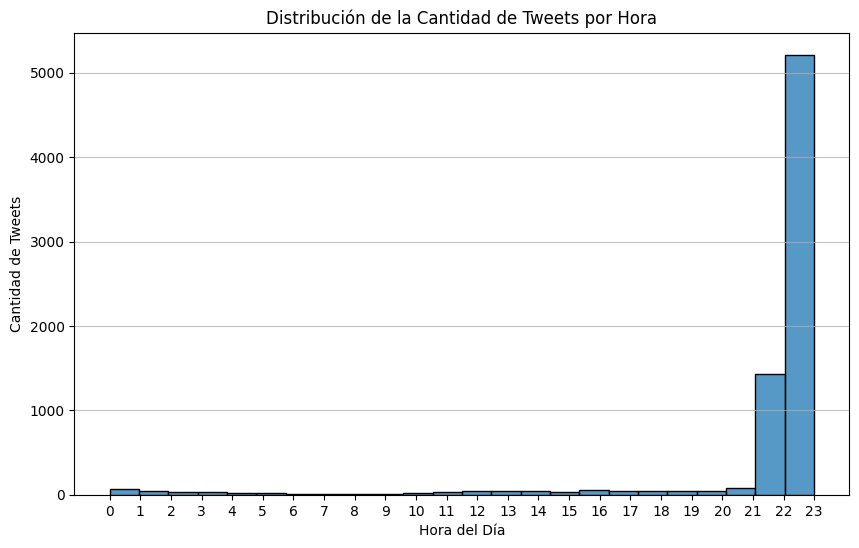

In [43]:
# Histograma de la distribución de tweets por hora
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_hour'], bins=24, kde=False) # Usamos 24 bins para cada hora
plt.title('Distribución de la Cantidad de Tweets por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Tweets')
plt.xticks(range(24)) # Asegurar que se muestren todas las horas si hay datos
plt.grid(axis='y', alpha=0.75)
plt.show()

**Visualización Temporal de los Tweets por Hora**

Para tener una idea más clara de en qué momentos del día se publican más tweets, vamos a visualizar la cantidad de tweets por hora en un gráfico.

**Visualización Temporal de los Tweets por Hora**

Para tener una idea más clara de en qué momentos del día se publican más tweets, vamos a visualizar la cantidad de tweets por hora en un gráfico.

In [44]:
# Extraer la hora y el día
tweets['tweet_hour'] = tweets['fecha'].dt.hour
tweets['tweet_day'] = tweets['fecha'].dt.day_name()

# Contar tweets por día y por hora
tweets_per_day = tweets['tweet_day'].value_counts()
tweets_per_hour = tweets['tweet_hour'].value_counts().sort_index()

print("Cantidad de tweets por día:")
display(tweets_per_day)

print("\nCantidad de tweets por hora:")
display(tweets_per_hour)

Cantidad de tweets por día:


,count
tweet_day,
Thursday,4764
Monday,1124
Tuesday,1107
Friday,134
Sunday,128
Saturday,99
Wednesday,70



Cantidad de tweets por hora:


,count
tweet_hour,
0,62
1,43
2,38
3,35
4,20
5,20
6,6
7,6
8,7


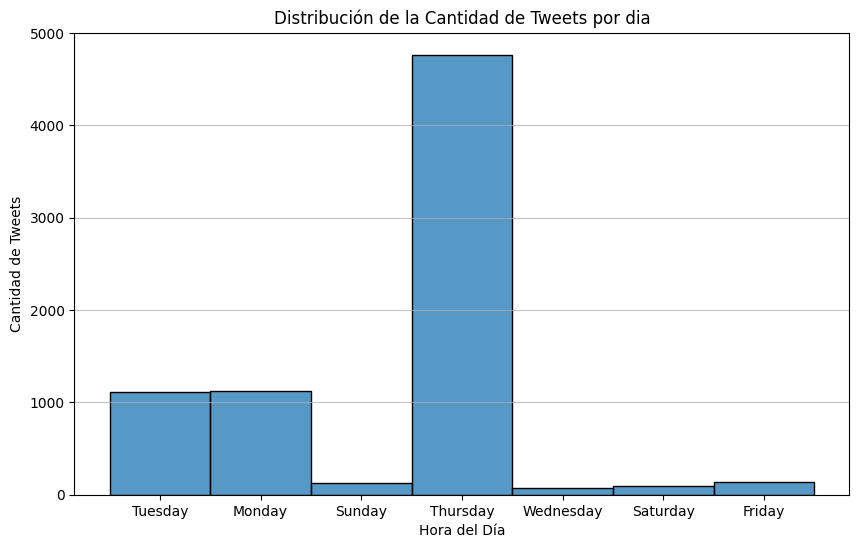

In [45]:
# Histograma de la distribución de tweets por hora
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_day'], bins=24, kde=False) # Usamos 24 bins para cada hora
plt.title('Distribución de la Cantidad de Tweets por dia')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Tweets')
plt.xticks(range(7)) # Asegurar que se muestren todas las horas si hay datos
plt.grid(axis='y', alpha=0.75)
plt.show()

In [55]:

login("token")


df = pd.read_csv("tweets_base3.csv")
df = df.dropna(subset=["tweet"])

# Cargar el modelo BETO contextualizado para odio en español
model_name = "piuba-bigdata/beto-contextualized-hate-speech"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#  Función de clasificación (multi-etiqueta)
def clasificar_contextualizado(text, context=""):
    # este modelo acepta: "texto [SEP] contexto"
    entrada = f"{text} [SEP] {context}"
    inputs = tokenizer(
        entrada,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits[0]
    # convierte cada etiqueta a True/False ( > 0 )
    preds = (logits > 0).cpu().numpy().tolist()
    labels = model.config.id2label
    return {labels[i]: preds[i] for i in range(len(preds))}

#  Aplicar sobre todos los tweets (sin contexto extra por ahora)
df["predicciones"] = df["tweet"].apply(lambda t: clasificar_contextualizado(t, ""))

#  Extraer etiqueta “POLITICS” (por ejemplo) o “hate vs no hate”
# Por simplicidad: si alguna de las etiquetas es True → consideramos “odio”
def etiqueta_odio(dct):
    # dct es dict con: {"WOMEN": True/False, "POLITICS": ..., etc.}
    return 1 if any(dct.values()) else 0

df["odio_binario"] = df["predicciones"].apply(etiqueta_odio)

#  Contar y ver porcentaje
conteo = df["odio_binario"].value_counts().rename({0: "No odio", 1: "Odio"})
total = len(df)
porcentaje_odio = (conteo.get(1, 0) / total) * 100
print("Conteo de tweets:")
print(conteo)
print(f"Porcentaje de tweets con odio: {porcentaje_odio:.2f}%")

#  Guardar resultados
df.to_csv("tweets_clasificados_contextualizado.csv", index=False)
print("Archivo guardado como tweets_clasificados_contextualizado.csv")



HTTPError: Invalid user token.

In [54]:
import pandas as pd

# Cargar tu CSV clasificado
df = pd.read_csv("tweets_clasificados_contextualizado.csv")

# Conteo de odio vs no odio
conteo = df["odio_binario"].value_counts().rename({0: "No odio", 1: "Odio"})
total = len(df)
total_odio = conteo.get("Odio", conteo.get(1, 0))
porcentaje_odio = (total_odio / total) * 100

print("\n📊 Conteo:")
print(conteo)
print(f"\n🔥 Total de tweets con odio: {total_odio} de {total}")
print(f"📈 Porcentaje de tweets con odio: {porcentaje_odio:.2f}%")



📊 Conteo:
odio_binario
No odio    4098
Odio       3328
Name: count, dtype: int64

🔥 Total de tweets con odio: 3328 de 7426
📈 Porcentaje de tweets con odio: 44.82%


/tmp/ipython-input-925368123.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_odio = conteo.get("Odio", conteo.get(1, 0))
